## Load libs

In [378]:
from utils.epg import *
import matplotlib.pyplot as plt
from copy import copy
cmap = copy(plt.cm.get_cmap("jet"))
from scipy.optimize import least_squares

In [414]:
#whenever want to reload libraries
import importlib
import utils
importlib.reload(utils.epg)
from utils.epg import *

In [380]:
degree = r"${}^{\circ}$"
GeV = "GeV"
GeV2 = "GeV"+r"${}^{2}$"
GeVc = "GeV/c"
GeVc2 = "(GeV/c)"+r"${}^{2}$"

In [381]:
import matplotlib
# initial settings
pgf_with_latex = {
		"pgf.texsystem": "pdflatex",
		"text.usetex": True,            # use LaTeX to write all text
		"font.family": "sans-serif",         
		"font.sans-serif": "Helvetica",
		"font.size": 25,				# default font size
		"axes.labelsize": 24,			# x and y label size
		"axes.titlesize": 24,           # subfigure title size, i.e. title size when one figure
		"legend.fontsize": 22,			# legend size
		"xtick.labelsize": 23,			# x axis tick label size
		"ytick.labelsize": 23,			# y axis tick label 
		"figure.titlesize": 25,         # Figure title size, useful when you have multiple plots in one canvas.
		"pgf.preamble": r"\usepackage{xcolor}"     # xcolor for colours
}
matplotlib.rcParams.update(pgf_with_latex)


## Load simulational data

perform momentum corrections that we did at [previous nb](ProtonMomentumCorrection2.ipynb).

In [415]:
#pi0 simulation from Andrey, inb, rec
fname = "~/Dropbox (MIT)/data/MC/dnp/pi0DNPInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
pi0MCdnpInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_ep": epg.df_ep, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC":epg.df_MC}

In [399]:
dvpi0 = pi0MCdnpInbCorrected["dvpi0"]
df_MC = pi0MCdnpInbCorrected["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi0["Pp"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], dvpi0["Ppz"]])
dvpi0["MCPpt"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], 0])
dvpi0["Ppt"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], 0])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]<0.1]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]>-0.025]
# dvpi02 = dvpi02[np.abs(dvpi02["MCPp"]-dvpi02["Pp"]-correction(res_lsq, dvpi02["Pp"]))<0.02]

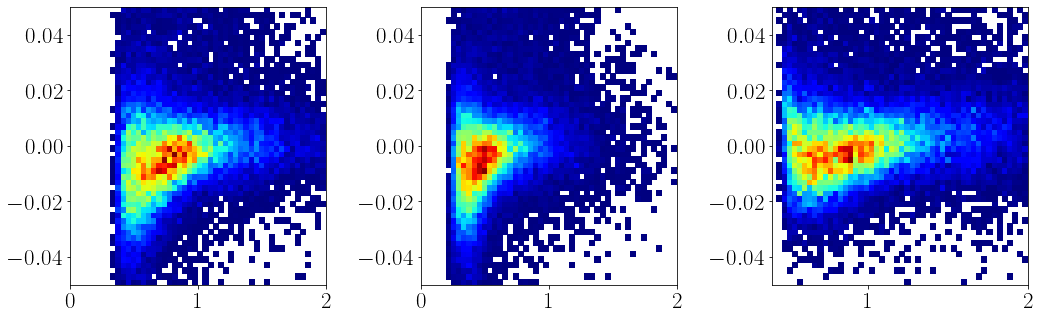

In [407]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist2d(dvpi02.Ppz, dvpi02.MCPpt-dvpi02.Ppt, bins = [np.linspace(0,2, 51), np.linspace(-0.05, 0.05, 51)], cmin = 1, cmap = cmap)
ax[1].hist2d(dvpi02.Ppt, dvpi02.MCPpt-dvpi02.Ppt, bins = [np.linspace(0, 2, 51), np.linspace(-.05, .05, 51)], cmin = 1, cmap = cmap)
ax[2].hist2d(dvpi02.Pp, dvpi02.MCPpz-dvpi02.Ppz, bins = [np.linspace(0.4, 2, 51), np.linspace(-.05, .05, 51)], cmin = 1, cmap = cmap)
# ax[1].hist2d(dvpi02.Ppt, dvpi02.MCPpt-dvpi02.Ppt, bins = [np.linspace(0, 2, 51), np.linspace(-.05, .05, 51)], cmin = 1, cmap = cmap)
# ax[2].hist2d(dvpi02.Pp, dvpi02.MCPpt-dvpi02.Ppt, bins = [np.linspace(0, 2, 51), np.linspace(-.05, .05, 51)], cmin = 1, cmap = cmap)
# ax[1].plot(np.linspace(0.2, 2, 101), correction(res_lsq, np.linspace(0.2, 2, 101)), color='k', linewidth=4)
plt.tight_layout()
plt.show()


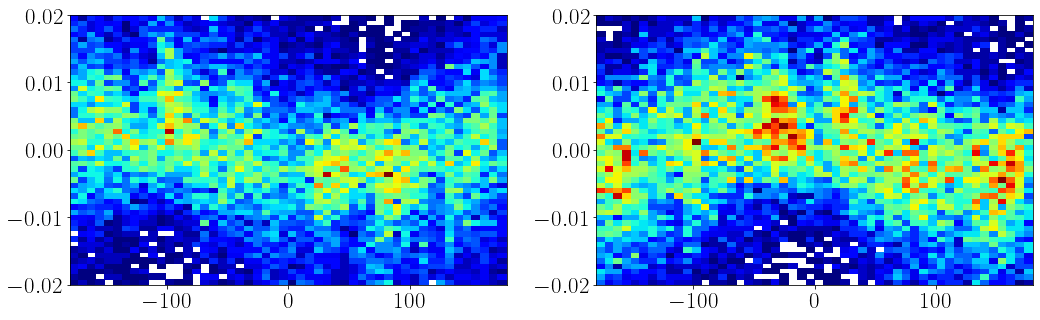

In [400]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d(dvpi02.Pphi, (dvpi02["MCPpx"]-dvpi02["Ppx"]), bins = [np.linspace(-180 , 180, 51), np.linspace(-0.02 , 0.02, 51)], cmin = 1, cmap = cmap)
# ax[0].plot(np.linspace(-180, 180, 101), correction3(np.linspace(-180, 180, 101)), color='k', linewidth=4)
# ax[0].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
# ax[0].set_xlabel("$p$"+ " [" + GeV + "]")

ax[1].hist2d(dvpi02.Pphi, (dvpi02["MCPpy"]-dvpi02["Ppy"]), bins = [np.linspace(-180 , 180, 51), np.linspace(-0.02 , 0.02, 51)], cmin = 1, cmap = cmap)
# ax[1].plot(np.linspace(-180, 180, 101), correction4(np.linspace(-180, 180, 101)), color='k', linewidth=4)
# ax[1].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
# ax[1].set_xlabel("$p$"+ " [" + GeV + "]")

plt.tight_layout()
# plt.show()
# plt.savefig("correction_answer.pdf")

In [86]:
def correction(res_lsq, t):
    x0, x1, x2 = res_lsq.x
    return x0 + x1*np.exp(x2*t)

In [117]:
# def fun(x, t, y):
#     return x[0]*np.exp(x[1]*t) - y
# x0 = np.ones(2)
# x0[1] = -1
dvpi02 = dvpi02[dvpi02["MCPpt"]-dvpi02["Ppt"]<0.04]
dvpi02 = dvpi02[dvpi02["MCPpt"]-dvpi02["Ppt"]>-0.02]

def fun(x, t, y):
    return x[0] + x[1]*np.exp(x[2]*t) - y
x0 = [0, 0.28460921, -5.12699082]

# for i in range (0, 100):
res_lsq = least_squares(fun, x0, args=(dvpi02["Ppt"], dvpi02["MCPpt"]-dvpi02["Ppt"]))
#     dvpi02 = dvpi02[np.abs(dvpi02["MCPpt"]-dvpi02["Ppt"]-correction(res_lsq, dvpi02["Pp"]))<0.02]
print(res_lsq.x)



[-2.09836849e-03  1.29946629e-01 -8.37646595e+00]


## Reload the data

In [352]:
#whenever want to reload libraries
import importlib
import utils
importlib.reload(utils.epg)
from utils.epg import *

In [408]:
#pi0 simulation from Andrey, inb, rec
fname = "~/Dropbox (MIT)/data/MC/dnp/pi0DNPInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
pi0MCdnpInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_ep": epg.df_ep, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC":epg.df_MC}

In [416]:
#dvcs from simulation, vz correct, vxvy (0, 0), rec
fname = "~/Dropbox (MIT)/data/MC/nonradVzCorrInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
dvcsMCInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC": epg.df_MC}

In [417]:
dvpi0 = pi0MCdnpInbCorrected["dvpi0"]
df_MC = pi0MCdnpInbCorrected["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi0["Pp"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], dvpi0["Ppz"]])
dvpi0["MCPpt"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], 0])
dvpi0["Ppt"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], 0])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]<0.1]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]>-0.025]
# dvpi02 = dvpi02[np.abs(dvpi02["MCPp"]-dvpi02["Pp"]-correction(res_lsq, dvpi02["Pp"]))<0.02]

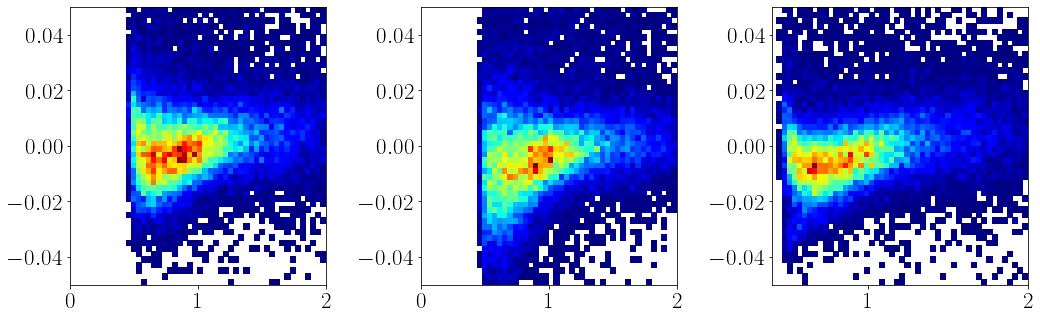

In [418]:
#check quality of correction
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist2d(dvpi02.Pp, dvpi02.MCPpz-dvpi02.Ppz, bins = [np.linspace(0,2, 51), np.linspace(-0.05, 0.05, 51)], cmin = 1, cmap = cmap)
ax[1].hist2d(dvpi02.Pp, dvpi02.MCPpt-dvpi02.Ppt, bins = [np.linspace(0, 2, 51), np.linspace(-.05, .05, 51)], cmin = 1, cmap = cmap)
ax[2].hist2d(dvpi02.Pp, dvpi02.MCPp-dvpi02.Pp, bins = [np.linspace(0.4, 2, 51), np.linspace(-.05, .05, 51)], cmin = 1, cmap = cmap)
plt.tight_layout()
plt.show()


In [420]:
(dvpi02.MCPp-dvpi02.Pp).mean()

0.008815494111056097

In [421]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/pi0_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
pi0ExpInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

[]

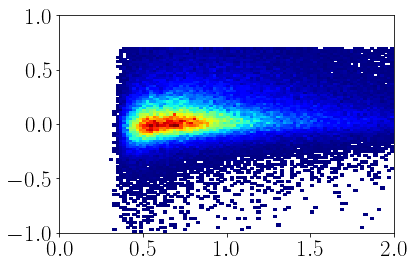

In [379]:
dvpi0Indata = epg.getDVpi0(correction=True)
df_epgg = copy(dvpi0Indata)
# plt.hist2d(dvpi0Indata.Pp, dvpi0Indata.MM2_ep, bins = [np.linspace(0,2,101), np.linspace(-1, 1,101)], cmap = cmap, cmin = 1)
pro = [df_epgg['Ppx'], df_epgg['Ppy'], df_epgg['Ppz']]
df_epgg.loc[:, 'Pe'] = getEnergy(pro, M)
VmissPi0 = [-df_epgg["Epx"] - df_epgg["Ppx"], -df_epgg["Epy"] -
            df_epgg["Ppy"], pbeam - df_epgg["Epz"] - df_epgg["Ppz"]]
df_epgg.loc[:,'MM2_ep'] = (-M - ebeam + df_epgg["Ee"] +
                     df_epgg["Pe"])**2 - mag2(VmissPi0)
plt.hist2d(df_epgg.Ppz, df_epgg.MM2_ep, bins = [np.linspace(0,2,101), np.linspace(-1, 1,101)], cmap = cmap, cmin = 1)
plt.plot()

In [422]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/dvcs_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
dvcsExpInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

0.03369992635242813
0.0005376663216736169


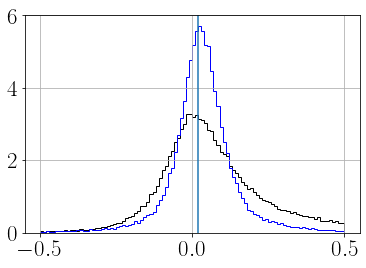

In [426]:
pi0ExpInbCorrected["dvpi0"].MM2_ep.hist(bins = np.linspace(-0.5, 0.5, 101), density= True, histtype='stepfilled', facecolor='none', edgecolor='k')
pi0MCdnpInbCorrected["dvpi0"].MM2_ep.hist(bins = np.linspace(-0.5, 0.5, 101), density=True, histtype='stepfilled', facecolor='none', edgecolor='b')
plt.axvline(x=0.135**2)
print(pi0MCdnpInbCorrected["dvpi0"].MM2_ep.mean())
print(pi0MCdnpInbCorrected["dvpi0"].MM2_ep.sem())
plt.show()

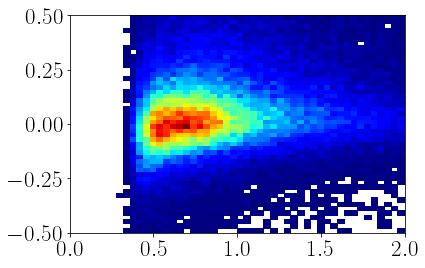

In [427]:
plt.hist2d(pi0ExpInbCorrected["dvpi0"].Ppz, pi0ExpInbCorrected["dvpi0"].MM2_ep, bins = [np.linspace(0,2, 51), np.linspace(-0.5 , 0.5, 51)], cmap=cmap, cmin = 1)
plt.show()

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


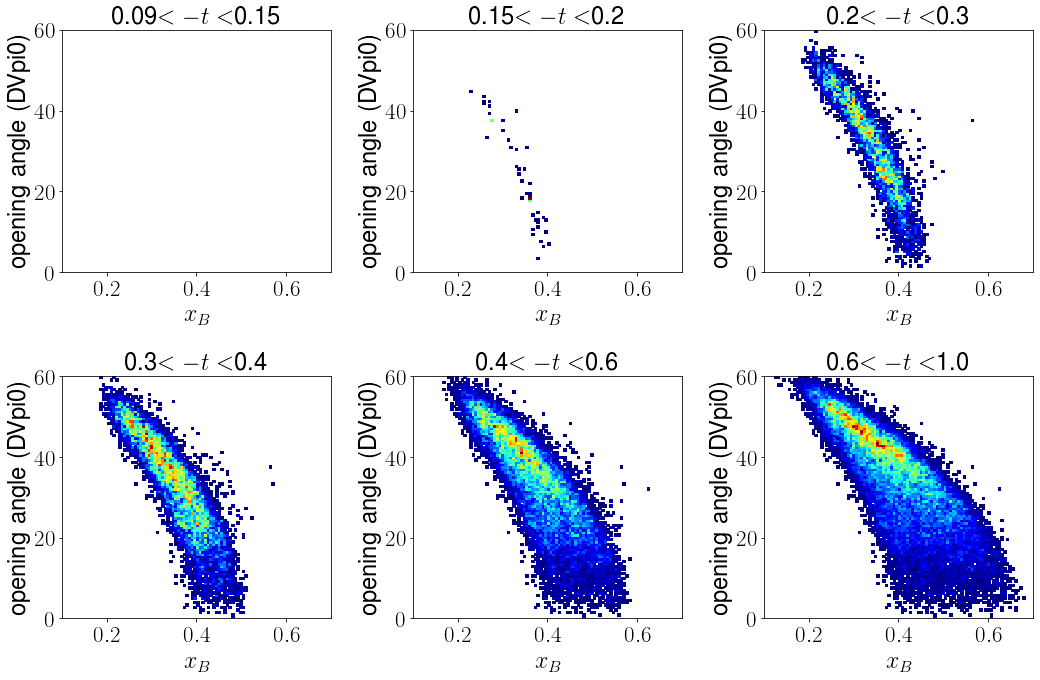

In [336]:
t_edges = [0.09, 0.15, 0.20, 0.3, 0.4, 0.60, 1.00, 1.5, 2.0]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        dvpi0 = pi0MCdnpInbCorrected["dvpi0"][pi0MCdnpInbCorrected["dvpi0"]["t"]>t_edges[ind]]
        dvpi0 = pi0MCdnpInbCorrected["dvpi0"][pi0MCdnpInbCorrected["dvpi0"]["t"]<t_edges[ind+1]]
        pro = [dvpi0['Ppx'], dvpi0['Ppy'], dvpi0['Ppz']]
        gam = [dvpi0['Gpx'], dvpi0['Gpy'], dvpi0['Gpz']]
        axs[yind, xind].hist2d(dvpi0.xB, angle(pro, gam), bins = [np.linspace(0.1, 0.7, 101), np.linspace(0, 60, 101)], cmap = cmap, cmin = 1)
        axs[yind, xind].set_title(str(t_edges[ind])+r"$<-t<$"+str(t_edges[ind+1]))
        axs[yind, xind].set_xlabel(r"$x_{B}$")
        axs[yind, xind].set_ylabel("opening angle (DVpi0)")
plt.tight_layout()
plt.savefig("DVpi0_higher_energy.pdf")

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


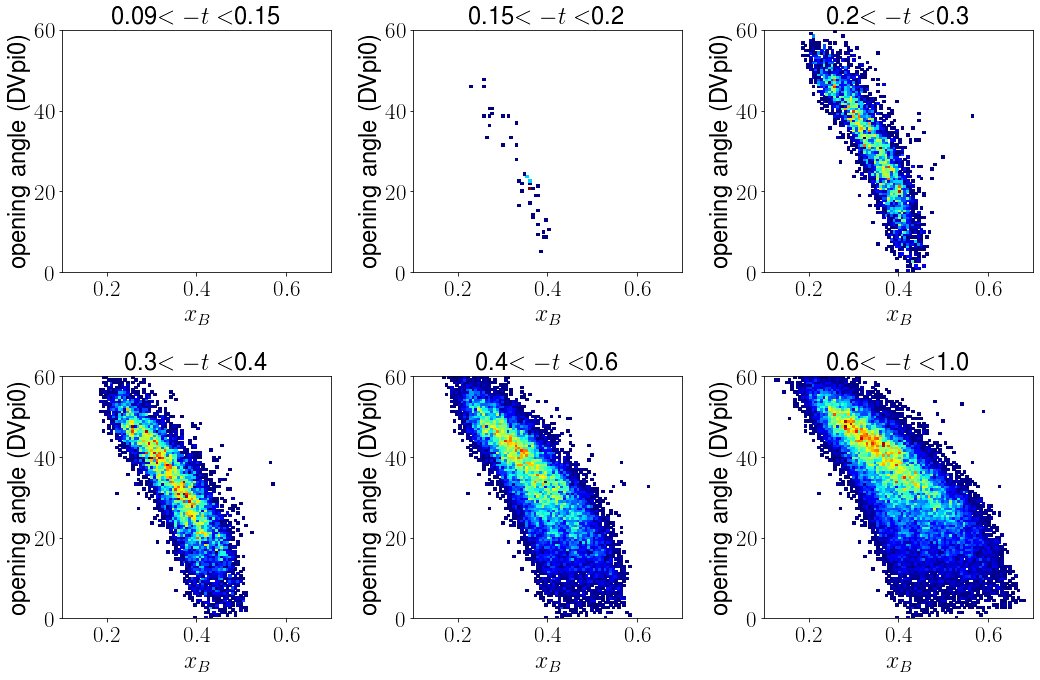

In [337]:
t_edges = [0.09, 0.15, 0.20, 0.3, 0.4, 0.60, 1.00, 1.5, 2.0]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        dvpi0 = pi0MCdnpInbCorrected["dvpi0"][pi0MCdnpInbCorrected["dvpi0"]["t"]>t_edges[ind]]
        dvpi0 = pi0MCdnpInbCorrected["dvpi0"][pi0MCdnpInbCorrected["dvpi0"]["t"]<t_edges[ind+1]]
        pro = [dvpi0['Ppx'], dvpi0['Ppy'], dvpi0['Ppz']]
        gam = [dvpi0['Gpx2'], dvpi0['Gpy2'], dvpi0['Gpz2']]
        axs[yind, xind].hist2d(dvpi0.xB, angle(pro, gam), bins = [np.linspace(0.1, 0.7, 101), np.linspace(0, 60, 101)], cmap = cmap, cmin = 1)
        axs[yind, xind].set_title(str(t_edges[ind])+r"$<-t<$"+str(t_edges[ind+1]))
        axs[yind, xind].set_xlabel(r"$x_{B}$")
        axs[yind, xind].set_ylabel("opening angle (DVpi0)")
plt.tight_layout()
plt.savefig("DVpi0_lower_energy.pdf")

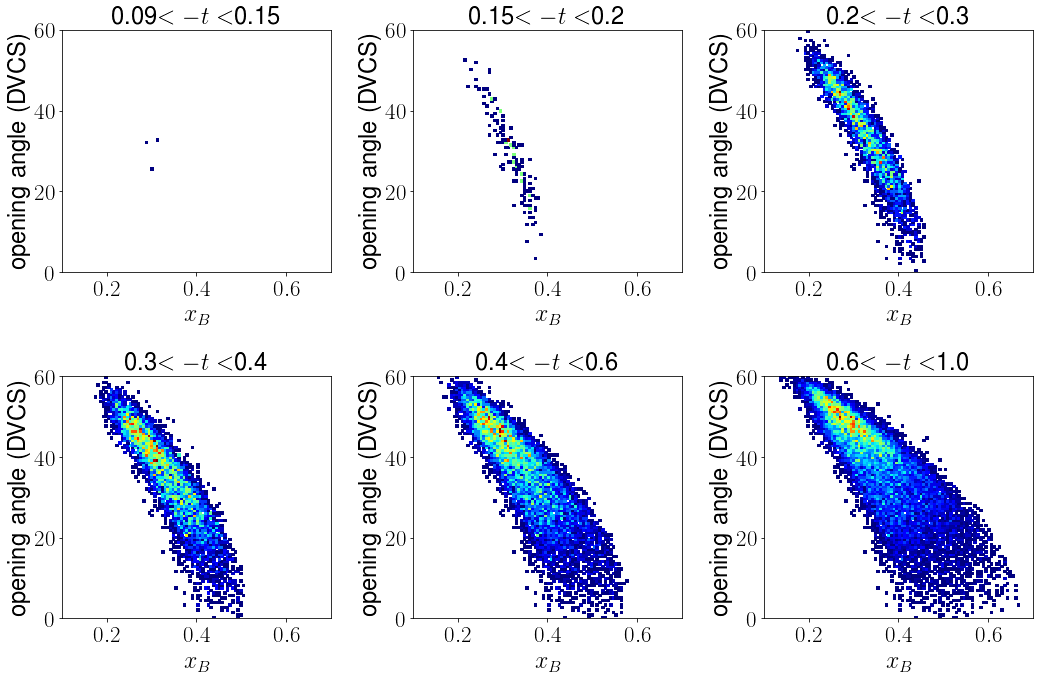

In [338]:
t_edges = [0.09, 0.15, 0.20, 0.3, 0.4, 0.60, 1.00, 1.5, 2.0]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        dvcs = dvcsMCInbCorrected["dvcs"][dvcsMCInbCorrected["dvcs"]["t2"]>t_edges[ind]]
        dvcs = dvcsMCInbCorrected["dvcs"][dvcsMCInbCorrected["dvcs"]["t2"]<t_edges[ind+1]]
        pro = [dvcs['Ppx'], dvcs['Ppy'], dvcs['Ppz']]
        gam = [dvcs['Gpx'], dvcs['Gpy'], dvcs['Gpz']]
        axs[yind, xind].hist2d(dvcs.xB, angle(pro, gam), bins = [np.linspace(0.1, 0.7, 101), np.linspace(0, 60, 101)], cmap = cmap, cmin = 1)
        axs[yind, xind].set_title(str(t_edges[ind])+r"$<-t<$"+str(t_edges[ind+1]))
        axs[yind, xind].set_xlabel(r"$x_{B}$")
        axs[yind, xind].set_ylabel("opening angle (DVCS)")
plt.tight_layout()
plt.savefig("DVCS.pdf")

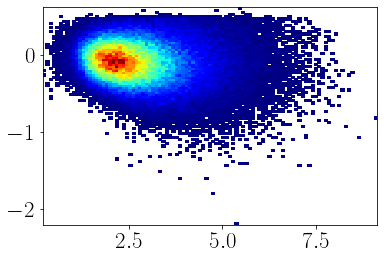

In [327]:
plt.hist2d(dvpi0Indata.Gpz, dvpi0Indata.Mpz-0.2, bins = 101, cmap = cmap, cmin = 1)
plt.show()

In [28]:
dvcsindvcs = dvcsExpInbCorrected["dvcs"]
dvpi0indvcs = dvcsExpInbCorrected["dvpi0"]
dvcsonlyindvcs = dvcsindvcs[~dvcsindvcs["event"].isin(dvpi0indvcs["event"])]


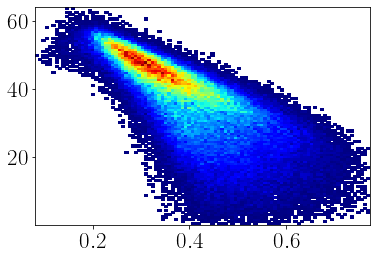

In [30]:
pro = [dvcsonlyindvcs['Ppx'], dvcsonlyindvcs['Ppy'], dvcsonlyindvcs['Ppz']]
gam = [dvcsonlyindvcs['Gpx'], dvcsonlyindvcs['Gpy'], dvcsonlyindvcs['Gpz']]
plt.hist2d(dvcsonlyindvcs.xB, angle(pro, gam), bins = 101, cmap = cmap, cmin =1)
plt.show()

In [384]:
pi0ExpInbProtonCorrected = pi0ExpInbCorrected
dvcsExpInbProtonCorrected = dvcsExpInbCorrected

In [424]:
dvpi0Indvpi0Sim = pi0MCdnpInbCorrected["dvpi0"]
alldvcsIndvpi0Sim = pi0MCdnpInbCorrected["dvcs"]
onlydvcsIndvpi0Sim = alldvcsIndvpi0Sim[~alldvcsIndvpi0Sim["event"].isin(dvpi0Indvpi0Sim["event"])]
alldvcsIndata = dvcsExpInbCorrected["dvcs"]
onlydvcsIndata = alldvcsIndata[~alldvcsIndata["event"].isin(dvcsExpInbCorrected["dvpi0"]["event"])]
dvpi0Indata = pi0ExpInbCorrected["dvpi0"]

# onlydvcsIndata = onlydvcsIndata[onlydvcsIndata["t2"]<1.7]
# dvpi0Indata.loc[:,'t'] = 2 * M * (dvpi0Indata['Pe'] - M)
# dvpi0Indata = dvpi0Indata[dvpi0Indata["t"]<1.7]
# onlydvcsIndvpi0Sim = onlydvcsIndvpi0Sim[onlydvcsIndvpi0Sim["t2"]<1.7]

print(len(onlydvcsIndata["event"].unique()), len(dvpi0Indata["event"].unique()), len(dvpi0Indata["event"].unique())* len(onlydvcsIndvpi0Sim["event"].unique())/len(dvpi0Indvpi0Sim["event"].unique()))
cont_inb = len(dvpi0Indata["event"].unique())* len(onlydvcsIndvpi0Sim["event"].unique())/len(dvpi0Indvpi0Sim["event"].unique())/len(onlydvcsIndata["event"].unique())
print(cont_inb)
print("the number of dvcs candidates in inbending: ", len(onlydvcsIndata["event"].unique()) - len(dvpi0Indata["event"].unique())* len(onlydvcsIndvpi0Sim["event"].unique())/len(dvpi0Indvpi0Sim["event"].unique()))

onlydvcsIndvcsSim = dvcsMCInbCorrected["dvcs"] 


113384 77736 23012.715876378254
0.20296263914113327
the number of dvcs candidates in inbending:  90371.28412362175


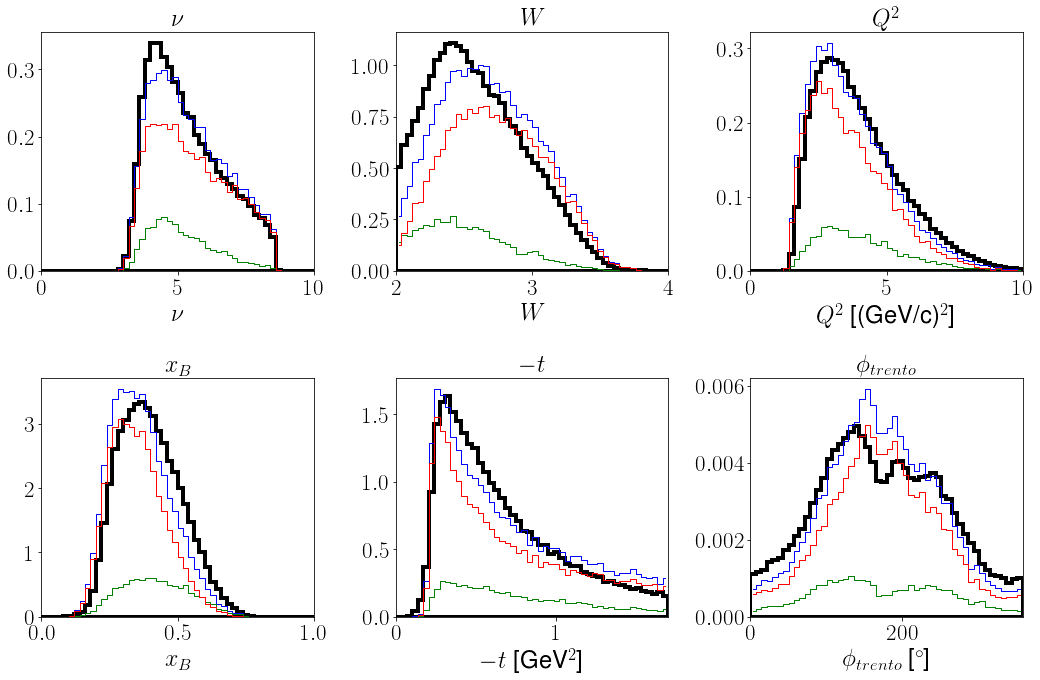

<Figure size 432x288 with 0 Axes>

In [425]:
varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [None, None, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [0, 2, 0, 0, 0, 0]
binends = [10, 4, 10, 1, 1.7, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
	for yind in range(0, 2):
		ind =xind+3*yind
		start = binstarts[ind]
		end = binends[ind]
		bins = np.linspace(start, end, 51)
		simDist_dvpi0, bins = np.histogram(onlydvcsIndvpi0Sim[varstoplot[ind]], bins, density = True)
		simDist_dvcs, bins = np.histogram(onlydvcsIndvcsSim[varstoplot[ind]], bins, density = True)
		simDist = cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs
		bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
		axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
		axs[yind, xind].bar(bincenters, simDist, width=np.diff(bins), color = 'w', facecolor='w')
		axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0, where='mid',color='g', linewidth=1)
		axs[yind, xind].bar(bincenters, cont_inb*simDist_dvpi0, width=np.diff(bins), color = 'w', facecolor='w')
		axs[yind, xind].step(bincenters, (1-cont_inb)*simDist_dvcs, where='mid',color='r', linewidth=1)
		axs[yind, xind].bar(bincenters, (1-cont_inb)*simDist_dvcs, width=np.diff(bins), color = 'w', facecolor='w')
		axs[yind, xind].hist(onlydvcsIndata[varstoplot[ind]], bins = bins, density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
		axs[yind, xind].set_title(title[ind])
		axs[yind, xind].set_xlim([start, end])
		if (unit[ind]):
			axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
		else:
			axs[yind, xind].set_xlabel(title[ind])
plt.tight_layout()
plt.show()
# plt.savefig("simComparison_2.pdf")
plt.clf()

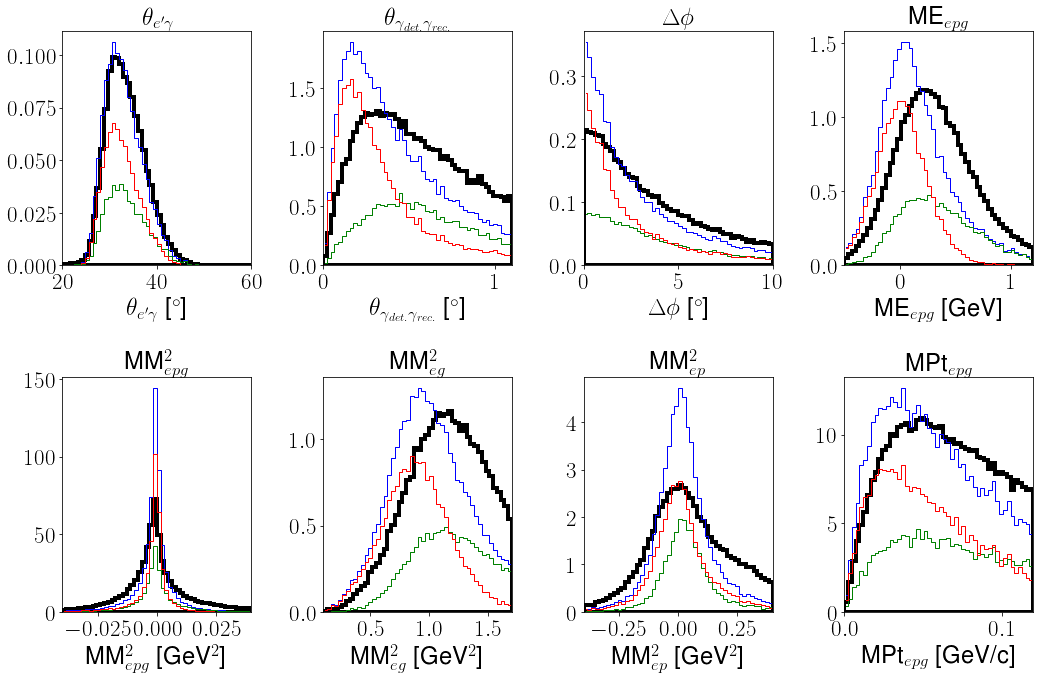

<Figure size 432x288 with 0 Axes>

In [12]:
varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [20, 0, 0, -0.5, -0.04, 0.1,-0.4 , 0]
binends = [60, 1.1, 10, 1.2, 0.04, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
	for xind in range(0,4):
		ind = 4*yind + xind
		start = binstarts[ind]
		end = binends[ind]
		bins = np.linspace(start, end, 51)
		simDist_dvpi0, bins = np.histogram(onlydvcsIndvpi0Sim[varstoplot[ind]], bins, density = True)
		simDist_dvcs, bins = np.histogram(onlydvcsIndvcsSim[varstoplot[ind]], bins, density = True)
		simDist = cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs
		bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
		axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
		axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0, where='mid',color='g', linewidth=1)
		axs[yind, xind].step(bincenters, (1-cont_inb)*simDist_dvcs, where='mid',color='r', linewidth=1)
		axs[yind, xind].hist(onlydvcsIndata[varstoplot[ind]], bins = bins, density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
		axs[yind, xind].set_title(title[ind])
		axs[yind, xind].set_xlim([start, end])
		if (unit[ind]):
			axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
		else:
			axs[yind, xind].set_xlabel(title[ind])
plt.tight_layout()
plt.show()
# plt.savefig("simComparison_2.pdf")
plt.clf()

-0.12941176470588237
-0.12941176470588237
0.0
-0.12941176470588237
-0.09411764705882353


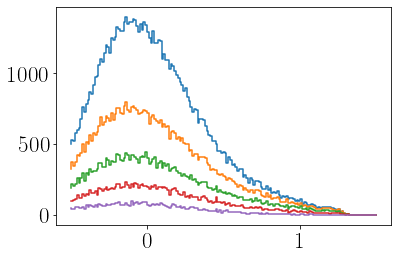

In [387]:
correction1 = 0.05
correction1 = np.select([onlydvcsIndata.Gpz>=3, (onlydvcsIndata.Gpz<3) & (onlydvcsIndata.Gpz>1), onlydvcsIndata.Gpz<=1],[0.13, 0 + 0.065*(onlydvcsIndata.Gpz-1), 0])

# plt.hist2d(onlydvcsIndata.Gp+correction1, onlydvcsIndata.Mpz-correction1, bins = [np.linspace(0, 10, 11), np.linspace(-.5, 1.2, 31)], cmap = cmap, cmin = 1)
# (onlydvcsIndata.Mpz-correction1).hist(bins = 101)
# (onlydvcsIndata.Mpz).hist(bins = 101,histtype ='stepfilled',facecolor='none',edgecolor='k')

# expDist_dvcs, bins = np.histogram(onlydvcsIndata.Mpz-0.05-correction1, np.linspace(-.5, 1.2, 51), density = True)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
# plt.step(bincenters, expDist_dvcs)
# print(bincenters[np.argmax(expDist_dvcs)])
for i in range(3, 8):
    dvcs = onlydvcsIndata[onlydvcsIndata.Gpz<i+1]
    dvcs = onlydvcsIndata[onlydvcsIndata.Gpz>i]
    correction1 = np.select([dvcs.Gpz>=3, (dvcs.Gpz<3) & (dvcs.Gpz>1), dvcs.Gpz<=1],[0.13, 0 + 0.065*(dvcs.Gpz-1), 0])
    expDist_dvcs, bins = np.histogram(dvcs.Mpz-0.06-correction1, np.linspace(-.5, 1.5, 171))
    bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
    plt.step(bincenters, expDist_dvcs)
    print(bincenters[np.argmax(expDist_dvcs)])

plt.show()


0.06500000000000006
0.06500000000000006
0.06500000000000006
0.11499999999999999
0.09499999999999997


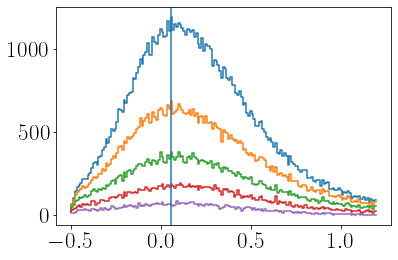

In [450]:
# correction1 = 0.05
# correction1 = np.select([onlydvcsIndata.Gpz>=3, (onlydvcsIndata.Gpz<3) & (onlydvcsIndata.Gpz>1), onlydvcsIndata.Gpz<=1],[0.13, 0 + 0.065*(onlydvcsIndata.Gpz-1), 0])

# plt.hist2d(onlydvcsIndata.Gp+correction1, onlydvcsIndata.Mpz-correction1, bins = [np.linspace(0, 10, 11), np.linspace(-.5, 1.2, 31)], cmap = cmap, cmin = 1)
# (onlydvcsIndata.Mpz-correction1).hist(bins = 101)
# (onlydvcsIndata.Mpz).hist(bins = 101,histtype ='stepfilled',facecolor='none',edgecolor='k')

# expDist_dvcs, bins = np.histogram(onlydvcsIndata.Mpz-0.05-correction1, np.linspace(-.5, 1.2, 51), density = True)
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
# plt.step(bincenters, expDist_dvcs)
# print(bincenters[np.argmax(expDist_dvcs)])
for i in range(3, 8):
    dvcs = onlydvcsIndata[onlydvcsIndata.Gpz<i+1]
    dvcs = onlydvcsIndata[onlydvcsIndata.Gpz>i]
#     correction1 = np.select([dvcs.Gpz>=3, (dvcs.Gpz<3) & (dvcs.Gpz>1), dvcs.Gpz<=1],[0.13, 0 + 0.065*(dvcs.Gpz-1), 0])
    expDist_dvcs, bins = np.histogram(dvcs.Mpz, np.linspace(-.5, 1.2, 171))
    bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
    plt.step(bincenters, expDist_dvcs)
    print(bincenters[np.argmax(expDist_dvcs)])

plt.axvline(x=0.06)
plt.show()


<AxesSubplot:>

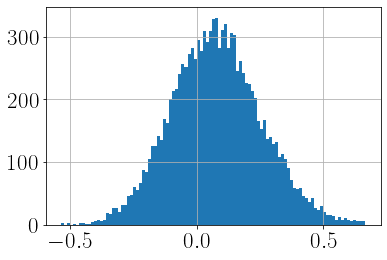

In [389]:
dvpi0 = dvpi0Indvpi0Sim[dvpi0Indvpi0Sim.Gpz<2]
dvpi0 = dvpi0[dvpi0.Gpz>0]
dvpi0.Mpz.hist(bins = 101)

-0.1175
-0.1175
-0.15149999999999997
-0.20249999999999996
-0.2365
-0.16849999999999998


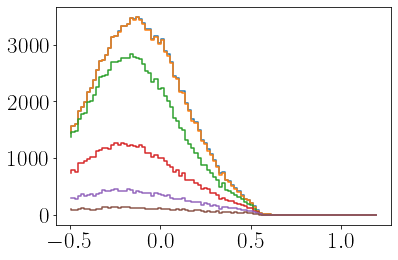

In [448]:
# dvpi0Indata = dvpi0Indata[dvpi0Indata.Gpz/4 + dvpi0Indata.Gpz2/6<1]
# dvpi0Indata = dvpi0Indata[dvpi0Indata.Gpz/2 + dvpi0Indata.Gpz2/3>1]
dvpi0Indata = pi0ExpInbCorrected["dvpi0"]
# dvpi0Indata = dvpi0Indata[dvpi0Indata.Gpz>3]
# dvpi0Indata = dvpi0Indata[dvpi0Indata.Gpz<4]
# dvpi0Indata.loc[dvpi0Indata["Gp"]>2, "Gpz"] = dvpi0Indata.loc[dvpi0Indata["Gp"]>2, "Gpz"] + 0.09514
correction1 = 0
correction2 = 0
correction1 = np.select([dvpi0Indata.Gpz>=2, (dvpi0Indata.Gpz<2) & (dvpi0Indata.Gpz>1), dvpi0Indata.Gpz<=1],[0.13, 0.13*(dvpi0Indata.Gpz-1), 0])
correction2 = np.select([dvpi0Indata.Gpz2>=2, (dvpi0Indata.Gpz2<2) & (dvpi0Indata.Gpz2>1), dvpi0Indata.Gpz2<=1],[0.13, 0.13*(dvpi0Indata.Gpz2-1), 0])

# plt.hist2d(dvpi0Indata.Gp+correction1, dvpi0Indata.Mpz-correction1-correction2, bins = [np.linspace(0, 10, 101), np.linspace(-.5, .5, 101)], cmap = cmap, cmin = 1)
# plt.hist2d(dvpi0Indata.Gpz2+correction2, dvpi0Indata.Mpz-correction1-correction2, bins = [np.linspace(0, 10, 101), np.linspace(-.5, .5, 101)], cmap = cmap, cmin = 1)
# print(dvpi0Indata.Mpz.mean())
# (dvpi0Indata.Mpz-correction1-correction2).hist(bins = np.linspace(-1.2, .5, 171))

# expDist_dvpi0, bins = np.histogram(dvpi0Indata.Mpz - correction1 - correction2, np.linspace(-.5, 1.2, 101), density = True)
# bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
# # plt.step(bincenters, expDist_dvpi0)
# print(bincenters[np.argmax(expDist_dvpi0)])


for i in range(0, 6):
    dvpi0 = dvpi0Indata[dvpi0Indata.Gpz<i+1]
    dvpi0 = dvpi0Indata[dvpi0Indata.Gpz>i]

    correction1 = 0
    correction2 = 0
    correction1 = np.select([dvpi0.Gpz>=2, (dvpi0.Gpz<2) & (dvpi0.Gpz>1), dvpi0.Gpz<=1],[0.13, 0.13*(dvpi0.Gpz-1), 0])
    correction2 = np.select([dvpi0.Gpz2>=2, (dvpi0.Gpz2<2) & (dvpi0.Gpz2>1), dvpi0.Gpz2<=1],[0.13, 0.13*(dvpi0.Gpz2-1), 0])
    expDist_dvpi0, bins = np.histogram(dvpi0.Mpz-correction1-correction2, np.linspace(-.5, 1.2, 101), density=False)
#     expDist_dvpi0, bins = np.histogram(dvpi0.Gpz2, np.linspace(0, 3, 101), density=False)
    bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
    plt.step(bincenters, expDist_dvpi0)
    print(bincenters[np.argmax(expDist_dvpi0)])


plt.show()

<AxesSubplot:>

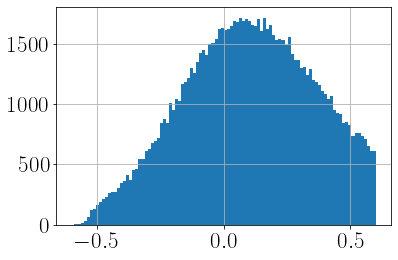

In [400]:
(onlydvcsIndata.Mpz-0.05).hist(bins=np.linspace(-0.6, 0.6, 101))

0.12050000000000005


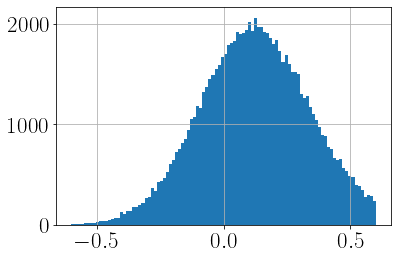

In [172]:
dvpi0Indata.Mpz.hist(bins=np.linspace(-0.6, 0.6, 101))
dist, bins = np.histogram(dvpi0Indata.Mpz, bins = np.linspace(-0.5, 1.2 ,101))
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
print(bincenters[np.argmax(dist)])

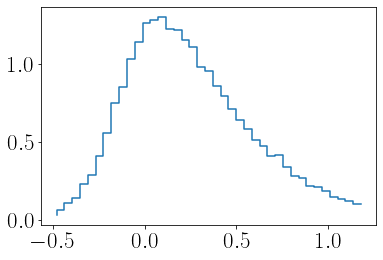

0.11624999999999996

In [455]:
simDist_dvpi0, bins = np.histogram(onlydvcsIndvpi0Sim["Mpz"], np.linspace(-0.5, 1.2, 41), density = True)
simDist_dvcs, bins = np.histogram(onlydvcsIndvcsSim["Mpz"], bins, density = True)
simDist = cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
plt.step(bincenters, simDist)
plt.show()
bincenters[np.argmax(simDist)]

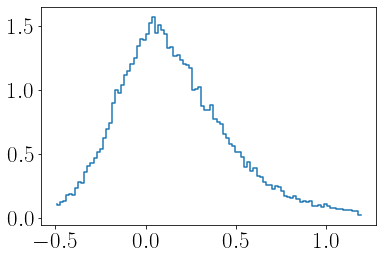

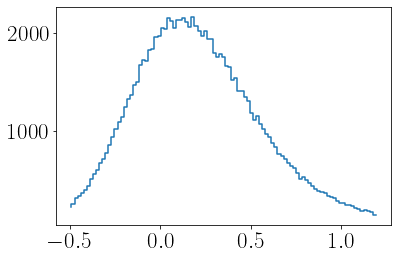

0.18850000000000006

In [456]:
dist, bins = np.histogram(onlydvcsIndata.ME_epg, np.linspace(-0.5, 1.2 ,101))
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
plt.step(bincenters, dist)
plt.show()
bincenters[np.argmax(dist)]

## Try rudimentary photon correction

In [431]:
#whenever want to reload libraries
import importlib
import utils
importlib.reload(utils.epg)
from utils.epg import *

In [432]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/pi0_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
pi0ExpInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [433]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/dvcs_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
dvcsExpInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [461]:
dvpi0Indvpi0Sim = pi0MCdnpInbCorrected["dvpi0"]
alldvcsIndvpi0Sim = pi0MCdnpInbCorrected["dvcs"]
onlydvcsIndvpi0Sim = alldvcsIndvpi0Sim[~alldvcsIndvpi0Sim["event"].isin(dvpi0Indvpi0Sim["event"])]
alldvcsIndata = dvcsExpInbCorrected["dvcs"]
# alldvcsIndata = dvcsExpInbProtonCorrected["dvcs"]
onlydvcsIndata = alldvcsIndata[~alldvcsIndata["event"].isin(dvcsExpInbCorrected["dvpi0"]["event"])]
dvpi0Indata = pi0ExpInbCorrected["dvpi0"]
# dvpi0Indata = pi0ExpInbProtonCorrected["dvpi0"]

# onlydvcsIndata = onlydvcsIndata[onlydvcsIndata["t2"]<1.7]
# dvpi0Indata.loc[:,'t'] = 2 * M * (dvpi0Indata['Pe'] - M)
# dvpi0Indata = dvpi0Indata[dvpi0Indata["t"]<1.7]
# onlydvcsIndvpi0Sim = onlydvcsIndvpi0Sim[onlydvcsIndvpi0Sim["t2"]<1.7]

print(len(onlydvcsIndata["event"].unique()), len(dvpi0Indata["event"].unique()), len(dvpi0Indata["event"].unique())* len(onlydvcsIndvpi0Sim["event"].unique())/len(dvpi0Indvpi0Sim["event"].unique()))
cont_inb = .6#len(dvpi0Indata["event"].unique())* len(onlydvcsIndvpi0Sim["event"].unique())/len(dvpi0Indvpi0Sim["event"].unique())/len(onlydvcsIndata["event"].unique())
print("the number of dvcs candidates in inbending: ", len(onlydvcsIndata["event"].unique())*(1-cont_inb))

107872 141401 41859.898086288995
the number of dvcs candidates in inbending:  43148.8


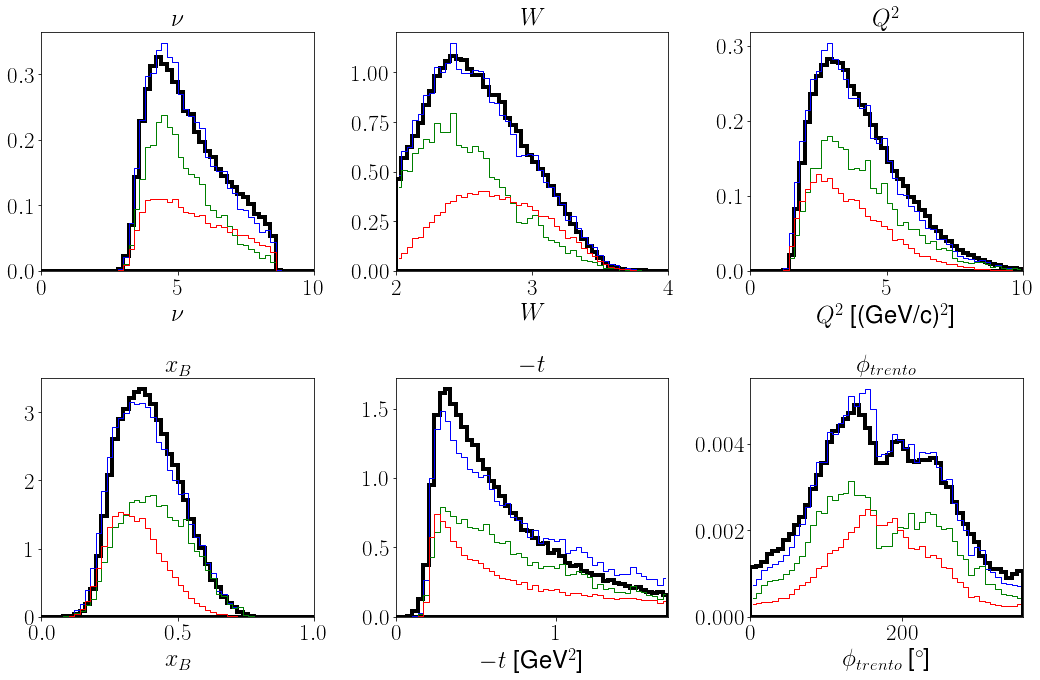

<Figure size 432x288 with 0 Axes>

In [462]:
onlydvcsIndvcsSim = dvcsMCInbCorrected["dvcs"] 
# onlydvcsIndvcsSim = onlydvcsIndvcsSim[onlydvcsIndvcsSim["t2"]<1.7]

varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [None, None, GeVc2, None, GeV2, degree, GeV2, degree]
binstarts = [0, 2, 0, 0, 0, 0]
binends = [10, 4, 10, 1, 1.7, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
	for yind in range(0, 2):
		ind =xind+3*yind
		start = binstarts[ind]
		end = binends[ind]
		bins = np.linspace(start, end, 51)
		simDist_dvpi0, bins = np.histogram(onlydvcsIndvpi0Sim[varstoplot[ind]], bins, density = True)
		simDist_dvcs, bins = np.histogram(onlydvcsIndvcsSim[varstoplot[ind]], bins, density = True)
		simDist = cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs
		bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
		axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
		axs[yind, xind].bar(bincenters, simDist, width=np.diff(bins), color = 'w', facecolor='w')
		axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0, where='mid',color='g', linewidth=1)
		axs[yind, xind].bar(bincenters, cont_inb*simDist_dvpi0, width=np.diff(bins), color = 'w', facecolor='w')
		axs[yind, xind].step(bincenters, (1-cont_inb)*simDist_dvcs, where='mid',color='r', linewidth=1)
		axs[yind, xind].bar(bincenters, (1-cont_inb)*simDist_dvcs, width=np.diff(bins), color = 'w', facecolor='w')
		axs[yind, xind].hist(onlydvcsIndata[varstoplot[ind]], bins = bins, density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
		axs[yind, xind].set_title(title[ind])
		axs[yind, xind].set_xlim([start, end])
		if (unit[ind]):
			axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
		else:
			axs[yind, xind].set_xlabel(title[ind])
plt.tight_layout()
plt.show()
# plt.savefig("simComparison_2.pdf")
plt.clf()

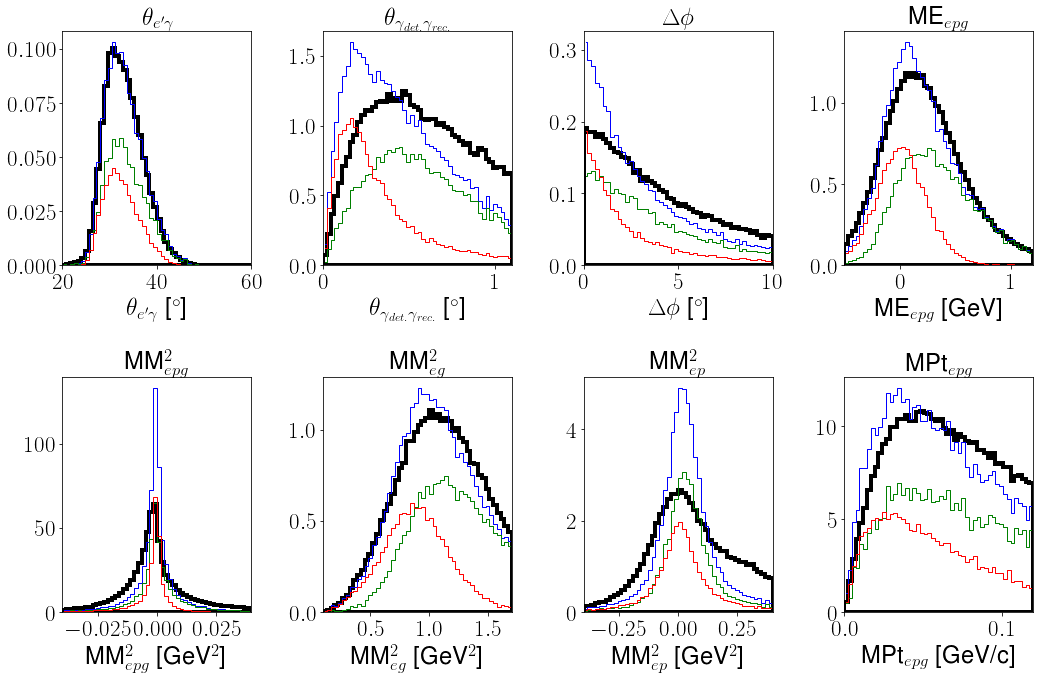

<Figure size 432x288 with 0 Axes>

In [463]:
onlydvcsIndvcsSim = dvcsMCInbCorrected["dvcs"] 
# onlydvcsIndvcsSim = onlydvcsIndvcsSim[onlydvcsIndvcsSim["t2"]<1.7]

varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [20, 0, 0, -0.5, -0.04, 0.1,-0.4 , 0]
binends = [60, 1.1, 10, 1.2, 0.04, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
	for xind in range(0,4):
		ind = 4*yind + xind
		start = binstarts[ind]
		end = binends[ind]
		bins = np.linspace(start, end, 51)
		simDist_dvpi0, bins = np.histogram(onlydvcsIndvpi0Sim[varstoplot[ind]], bins, density = True)
		simDist_dvcs, bins = np.histogram(onlydvcsIndvcsSim[varstoplot[ind]], bins, density = True)
		simDist = cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs
		bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
		axs[yind, xind].step(bincenters, simDist, where='mid',color='b', linewidth=1)
		axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0, where='mid',color='g', linewidth=1)
		axs[yind, xind].step(bincenters, (1-cont_inb)*simDist_dvcs, where='mid',color='r', linewidth=1)
		axs[yind, xind].hist(onlydvcsIndata[varstoplot[ind]], bins = bins, density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
		axs[yind, xind].set_title(title[ind])
		axs[yind, xind].set_xlim([start, end])
		if (unit[ind]):
			axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
		else:
			axs[yind, xind].set_xlabel(title[ind])
plt.tight_layout()
plt.show()
# plt.savefig("simComparison_2.pdf")
plt.clf()

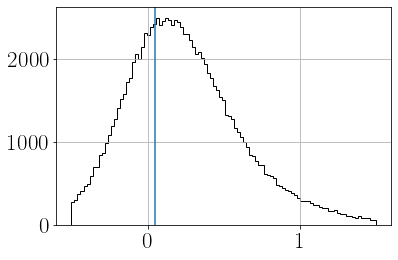

In [466]:
onlydvcsIndata.ME_epg.hist(bins = 101, histtype='stepfilled', facecolor='none', edgecolor='k')
plt.axvline(x=0.05)

<AxesSubplot:>

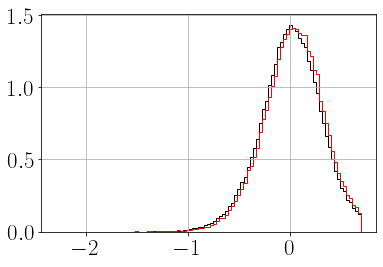

In [440]:
pi0ExpInbCorrected["dvpi0"].ME_epgg.hist(bins = 101, density=True, histtype='stepfilled', facecolor='none', edgecolor='k')
pi0ExpInbProtonCorrected["dvpi0"].ME_epgg.hist(bins=101, density=True, histtype='stepfilled', facecolor='none', edgecolor='r')

-0.04099999999999995


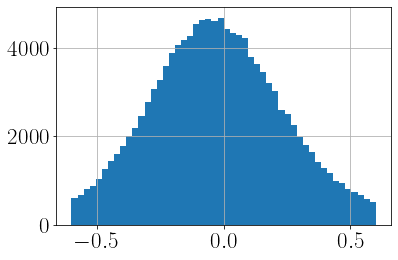

In [348]:
dvpi0Indata = pi0ExpInbCorrected["dvpi0"]
# dvpi0Indata = dvpi0Indata[dvpi0Indata.Gpz<3]
# dvpi0Indata.Gpz2.hist()
dvpi0Indata.Mpz.hist(bins=np.linspace(-0.6, 0.6, 51))
dist, bins = np.histogram(dvpi0Indata.Mpz, bins = np.linspace(-0.5, 1.2 ,51))
bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
print(bincenters[np.argmax(dist)])

-0.0037375182708300485


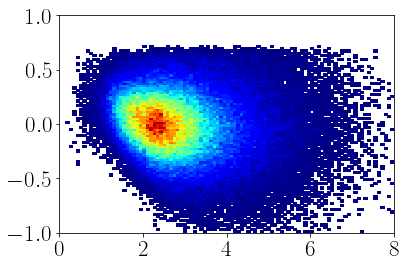

In [457]:
dvpi0Indata = pi0ExpInbCorrected["dvpi0"]
# dvpi0Indata = dvpi0Indata[dvpi0Indata.Gp>1.5]
# dvpi0Indata = dvpi0Indata[dvpi0Indata.Gp<2]
dvpi0Indata = dvpi0Indata[dvpi0Indata.Gp2<3]

# for i in range(0, 5):
#     dvpi0 = dvpi0Indata[dvpi0Indata.Gpz<2*i+2]
#     dvpi0 = dvpi0[dvpi0Indata.Gpz>2*i]
#     print(dvpi0.Mpz.mean())
plt.hist2d(dvpi0Indata.Gpz, dvpi0Indata.Mpz, bins = [np.linspace(0, 8, 101), np.linspace(-1, 1, 101)], cmap = cmap, cmin = 1)
# plt.hist2d(dvpi0Indata.Gpz, dvpi0Indata.Mpz, bins = [np.linspace(0, 10, 101), np.linspace(-0.5, 0.5, 101)], cmap = cmap, cmin = 1)
# plt.hist2d(dvpi0.Gpz, dvpi0.Mpz, bins = [np.linspace(0, 8, 9), np.linspace(-0.5, 0.5, 51)], cmap = cmap, cmin = 1)
print(dvpi0Indata.Mpz.mean())
plt.show()

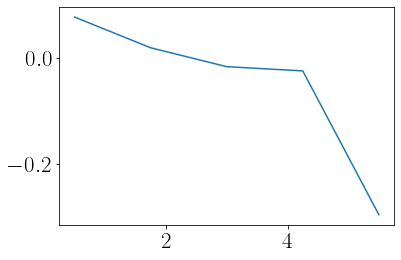

In [396]:
import scipy.stats
x = np.linspace(0.5, 5.5, 5)
y = [0.15650770680053383, 0.09814950882156769, 0.06227254102900083, 0.05417424861630607, -0.2189802928808463]
y = np.array(y)
y = y - y[0]/2


plt.plot(x,y)
# results = scipy.stats.linregress(x, y)

In [389]:
results

LinregressResult(slope=-0.021140583062484165, intercept=0.17683691543727714, rvalue=-0.9597581817030396, pvalue=4.138030040167833e-05, stderr=0.0023380088945240142, intercept_stderr=0.012129888175673445)

0.0034243164057496944


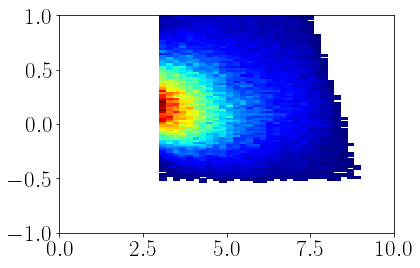

In [288]:
dvcsIndata = onlydvcsIndata
# dvpi0Indata = dvpi0Indata[np.abs(dvpi0Indata.Gpz-dvpi0Indata.Gpz2)<0.5]
# dvpi0Indata = dvpi0Indata[dvpi0Indata.Gpz/2 + dvpi0Indata.Gpz2/3>1]

plt.hist2d(dvcsIndata.Gp, dvcsIndata.Mpz, bins = [np.linspace(0, 10, 51), np.linspace(-1,1, 101)], cmap = cmap, cmin = 1)
# plt.hist2d(dvpi0Indata.Gpz, dvpi0Indata.Mpz-dvpi0Indata.Mpz.median(), bins = [np.linspace(0, 10, 101), np.linspace(-0.5, 0.5, 101)], cmap = cmap, cmin = 1)
print(dvpi0Indata.Mpz.median())
plt.show()

<AxesSubplot:>

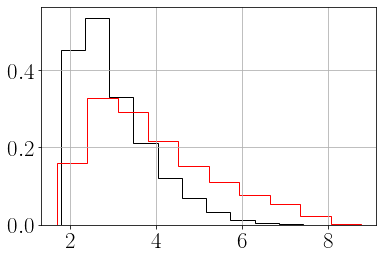

In [228]:
dvpi0Indata.Gpz.hist(density=True, histtype ='stepfilled', facecolor='none', edgecolor ='k')
dvcsExpInbCorrected["dvcs"].Gpz.hist(density=True, histtype ='stepfilled', facecolor='none', edgecolor ='r')

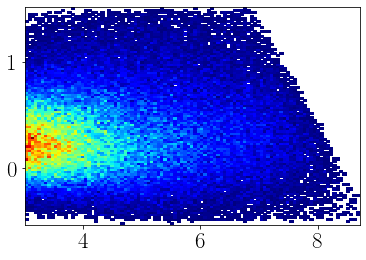

In [16]:
onlydvcsIndata = onlydvcsIndata[onlydvcsIndata.Gpz>3]
plt.hist2d(onlydvcsIndata.Gpz, onlydvcsIndata.Mpz, bins = 101, cmap = cmap, cmin = 1)
plt.show()

In [400]:
len(onlydvcsIndata)

93856

In [401]:
onlydvcsIndvpi0Sim = onlydvcsIndvpi0Sim[onlydvcsIndvpi0Sim.Gpz>3]

In [402]:
len(onlydvcsIndvpi0Sim)

14046